In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime as dt
import random
from skimage import transform
import mediapipe as mp

In [2]:
%matplotlib inline

In [3]:
seed_constant = 23
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
def total_sample_count(path):
    Total_sample=0
    for class_name in os.listdir(path):
        mp4_path = [i for i in os.listdir(f'AIFIT_DATASET/Data/{class_name}') if i.endswith('.mp4')]
        print(f'Length of :{class_name}= {len(mp4_path)}')
        Total_sample+=len(mp4_path)
    print(f'Total Samples:{Total_sample}')

In [5]:
total_sample_count('AIFIT_DATASET/Data')

Length of :Bicep Curl= 224
Length of :Overhead Press= 204
Length of :Shoulder Raise= 203
Length of :Squats= 169
Total Samples:800


In [6]:
# import imutils
# ipath = "C:/Users/bhave/OneDrive/Pictures/Camera Roll/WIN_20230123_13_23_24_Pro.mp4"
# # ipath = "C:/Users/bhave/Downloads/3.mp4"
# ipath = "E:/Final Year/Major/AiFit/AiFit Model/AIFIT_DATASET/Data/Fly/000000.mp4"
# video = cv2.VideoCapture(ipath)
# while True:
#     ret, frame = video.read()
#     if ret == True:
#         image_pose, marked_img, flag = detectPose(frame, pose_image,draw=True, display=False)
#         cv2.imshow("Foreground", marked_img)
#          # Use the q button to quit the operation
#         if cv2.waitKey(60) & 0xff == ord('q'):
#             break
#     else:
#         break
# cv2.destroyAllWindows()
# video.release()

In [7]:
# mp_selfie_segmentation = mp.solutions.selfie_segmentation
# selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

## VISUALIZING DATA

['Bicep Curl', 'Overhead Press', 'Shoulder Press', 'Squats']


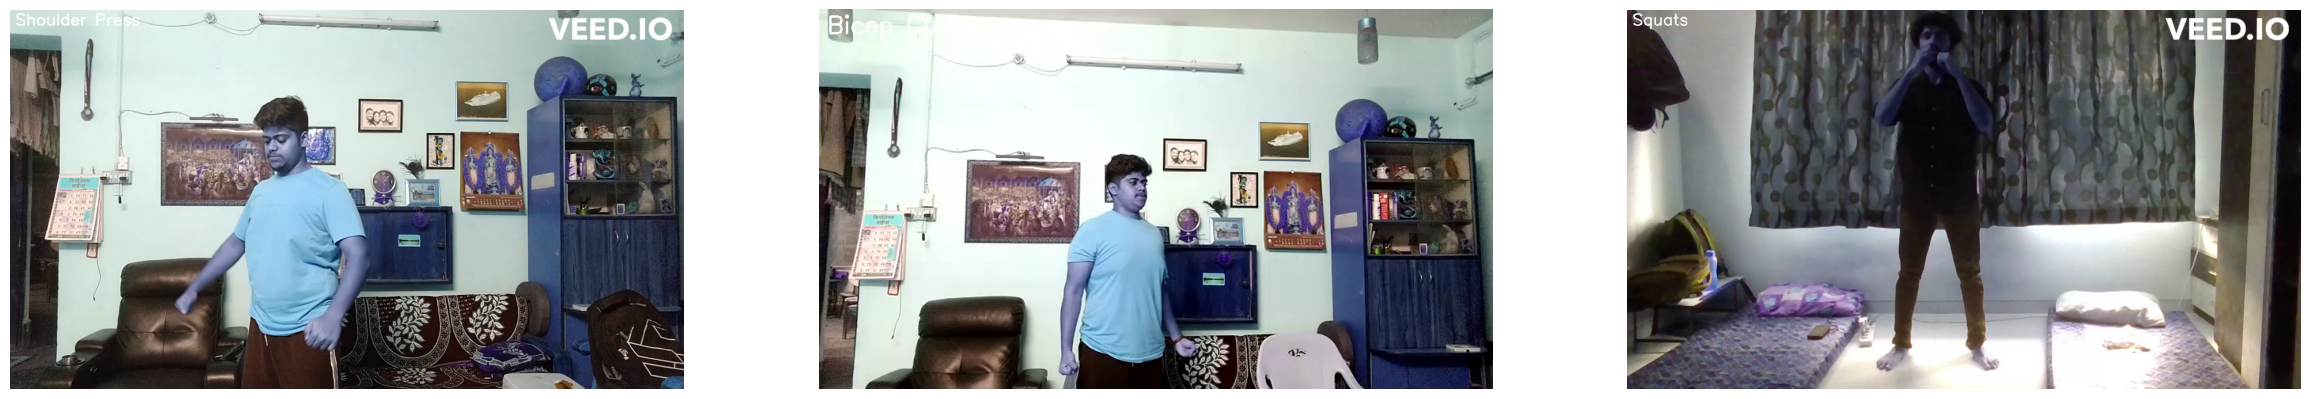

In [6]:
plt.figure(figsize = (40, 40))
all_classes_names = os.listdir('AIFIT_DATASET/Data/')
random_range = random.sample(range(len(all_classes_names)), len(all_classes_names)-1)

print(all_classes_names)
 
for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = [i for i in os.listdir(f'AIFIT_DATASET/Data/{selected_class_Name}') if i.endswith('.mp4')]
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'AIFIT_DATASET/Data/{selected_class_Name}/{selected_video_file_name}')    
    # Read the first frame of the video file.
    _, ir = video_reader.read() 
    video_reader.release()
#     gray_img = cv2.cvtColor(ir, cv2.COLOR_BGR2GRAY)
#     ir = cv2.applyColorMap(gray_img, cv2.COLORMAP_HOT)

#     ret, thresh = cv2.threshold(ir, 220, 100, cv2.THRESH_BINARY)
#     contours, hierarchy = cv2.findContours(image=gray_frame, mode=cv2.RETR_FLOODFILL, method=cv2.CHAIN_APPROX_NONE)                             
#     # draw contours on the original image
#     image_copy = gray_frame.copy()
#     cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)


#     img1 = rgb_frame.convert("L")
    cv2.putText(ir, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, counter);plt.imshow(ir);plt.axis('off')

## Skeletionization On Image Using Mediapipe

<h3 style="text-align:center">Mediapipe Joints</h3>
<br>
<br>

<img src="https://i.imgur.com/3j8BPdc.png" style="height:300px" >

In [7]:
# Initialize mediapipe pose class.
mp_pose = mp.solutions.pose

# Setup the Pose function for images - independently for the images standalone processing.
pose_image = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5)

# Setup the Pose function for videos - for video processing.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.7,
                          min_tracking_confidence=0.7)

# Initialize mediapipe drawing class - to draw the landmarks points.
mp_drawing = mp.solutions.drawing_utils

In [21]:
def detectPose(image_pose, pose,draw=False, display=False):
    flag = True
    image_in_RGB = cv2.cvtColor(image_pose, cv2.COLOR_BGR2RGB)
    resultant = pose.process(image_in_RGB)
    marked_img = np.zeros(image_pose.shape, dtype='uint8')
#     marked_img = image_pose
    if resultant.pose_landmarks == None:
        flag = False
        return image_pose, marked_img, flag
        
    if resultant.pose_landmarks and draw:    
        mp_drawing.draw_landmarks(image=marked_img, landmark_list=resultant.pose_landmarks,
                                  connections=mp_pose.POSE_CONNECTIONS,
                                  landmark_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,255),
                                                                               thickness=5, circle_radius=2),
                                  connection_drawing_spec=mp_drawing.DrawingSpec(color=(255,255,0),
                                                                               thickness=15, circle_radius=3))

    if display:
            plt.figure(figsize=[5,5])
            plt.subplot(121);plt.imshow(image_pose[:,:,::-1]);plt.title("Input Image");plt.axis('off');
            plt.subplot(122);plt.imshow(marked_img[:,:,::-1]);plt.title("Pose detected Image");plt.axis('off');

    else:
        return image_pose, marked_img, flag

## Data PREPROCESSING

In [22]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 25
CLASSES_LIST = ['Bicep Curl']

In [29]:
import sys
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
#     print(cv2.CAP_PROP_FRAME_COUNT)
#     print(video_frames_count)
#     print(skip_frames_window)
    seq_len = SEQUENCE_LENGTH
    frame_counter = 0
    increment = 0
    image_frame, marked_frame = None, None
    while seq_len:
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window + increment)
        success, frame = video_reader.read()
        
        if not success:
            break
        image_frame, marked_frame, flag = detectPose(frame, pose_image, draw=True, display=False, )
        plt.imshow(image_frame)
        plt.imshow(marked_frame)
#         marked_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
#         marked_img = cv2.applyColorMap(marked_img, cv2.COLORMAP_INFERNO)

#         RGB = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         marked_img = selfie_segmentation.process(RGB)
#         marked_frame = marked_img.segmentation_mask
        
        
#         resized_frame = cv2.resize(marked_frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        frames_list.append(marked_frame)
        seq_len -= 1
        frame_counter += 1
    
    video_reader.release()
    return image_frame, marked_frame

In [30]:
# def frames_extraction(video_path):
#     frames_list = []
#     video_reader = cv2.VideoCapture(video_path)
#     video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
#     skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
# #     print(cv2.CAP_PROP_FRAME_COUNT)
# #     print(video_frames_count)
# #     print(skip_frames_window)
#     frame_counter = 0
#     while video_frames_count:
#         video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter)
#         success, frame = video_reader.read()
        
#         if not success:
#             break
#         image_frame, marked_frame, flag = detectPose(frame, pose_image, draw=True, display=False, )
#         if not flag:
#             frame_counter += 1
#             continue
#         resized_frame = 
       
#         frames_list.append(resized_frame)
#         video_frames_count -= 1
#         frame_counter += 1
#     new_video_frames_count = len(frames_list)
#     new_skip_frames_window = max(int(new_video_frames_count/SEQUENCE_LENGTH), 1)
#     new_frames_list = []
#     for f in range(0, len(frames_list), new_skip_frames_window):
#         if len(new_frames_list) == SEQUENCE_LENGTH:
#             break
#         new_frames_list.append(frames_list[f])
#     frames_list = []
#     video_reader.release()
#     return new_frames_list

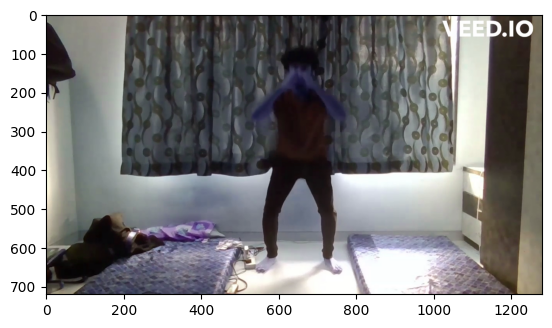

In [31]:
a, b = frames_extraction("C:/Users/bhave/Downloads/7.mp4")
plt.imshow(a)
# frame = frames_extraction("E:/Final Year/Major/AiFit/AiFit Model/AIFIT_DATASET/Data/Armraise/000050.mp4")

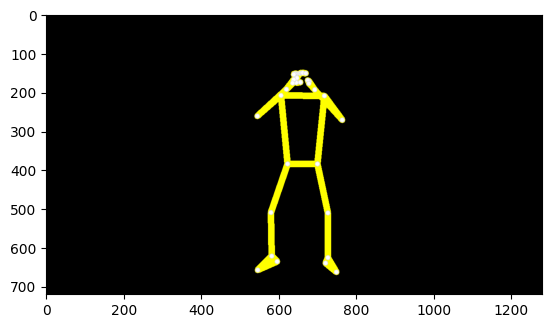

In [32]:
plt.imshow(b)

In [11]:
len(frame)

25

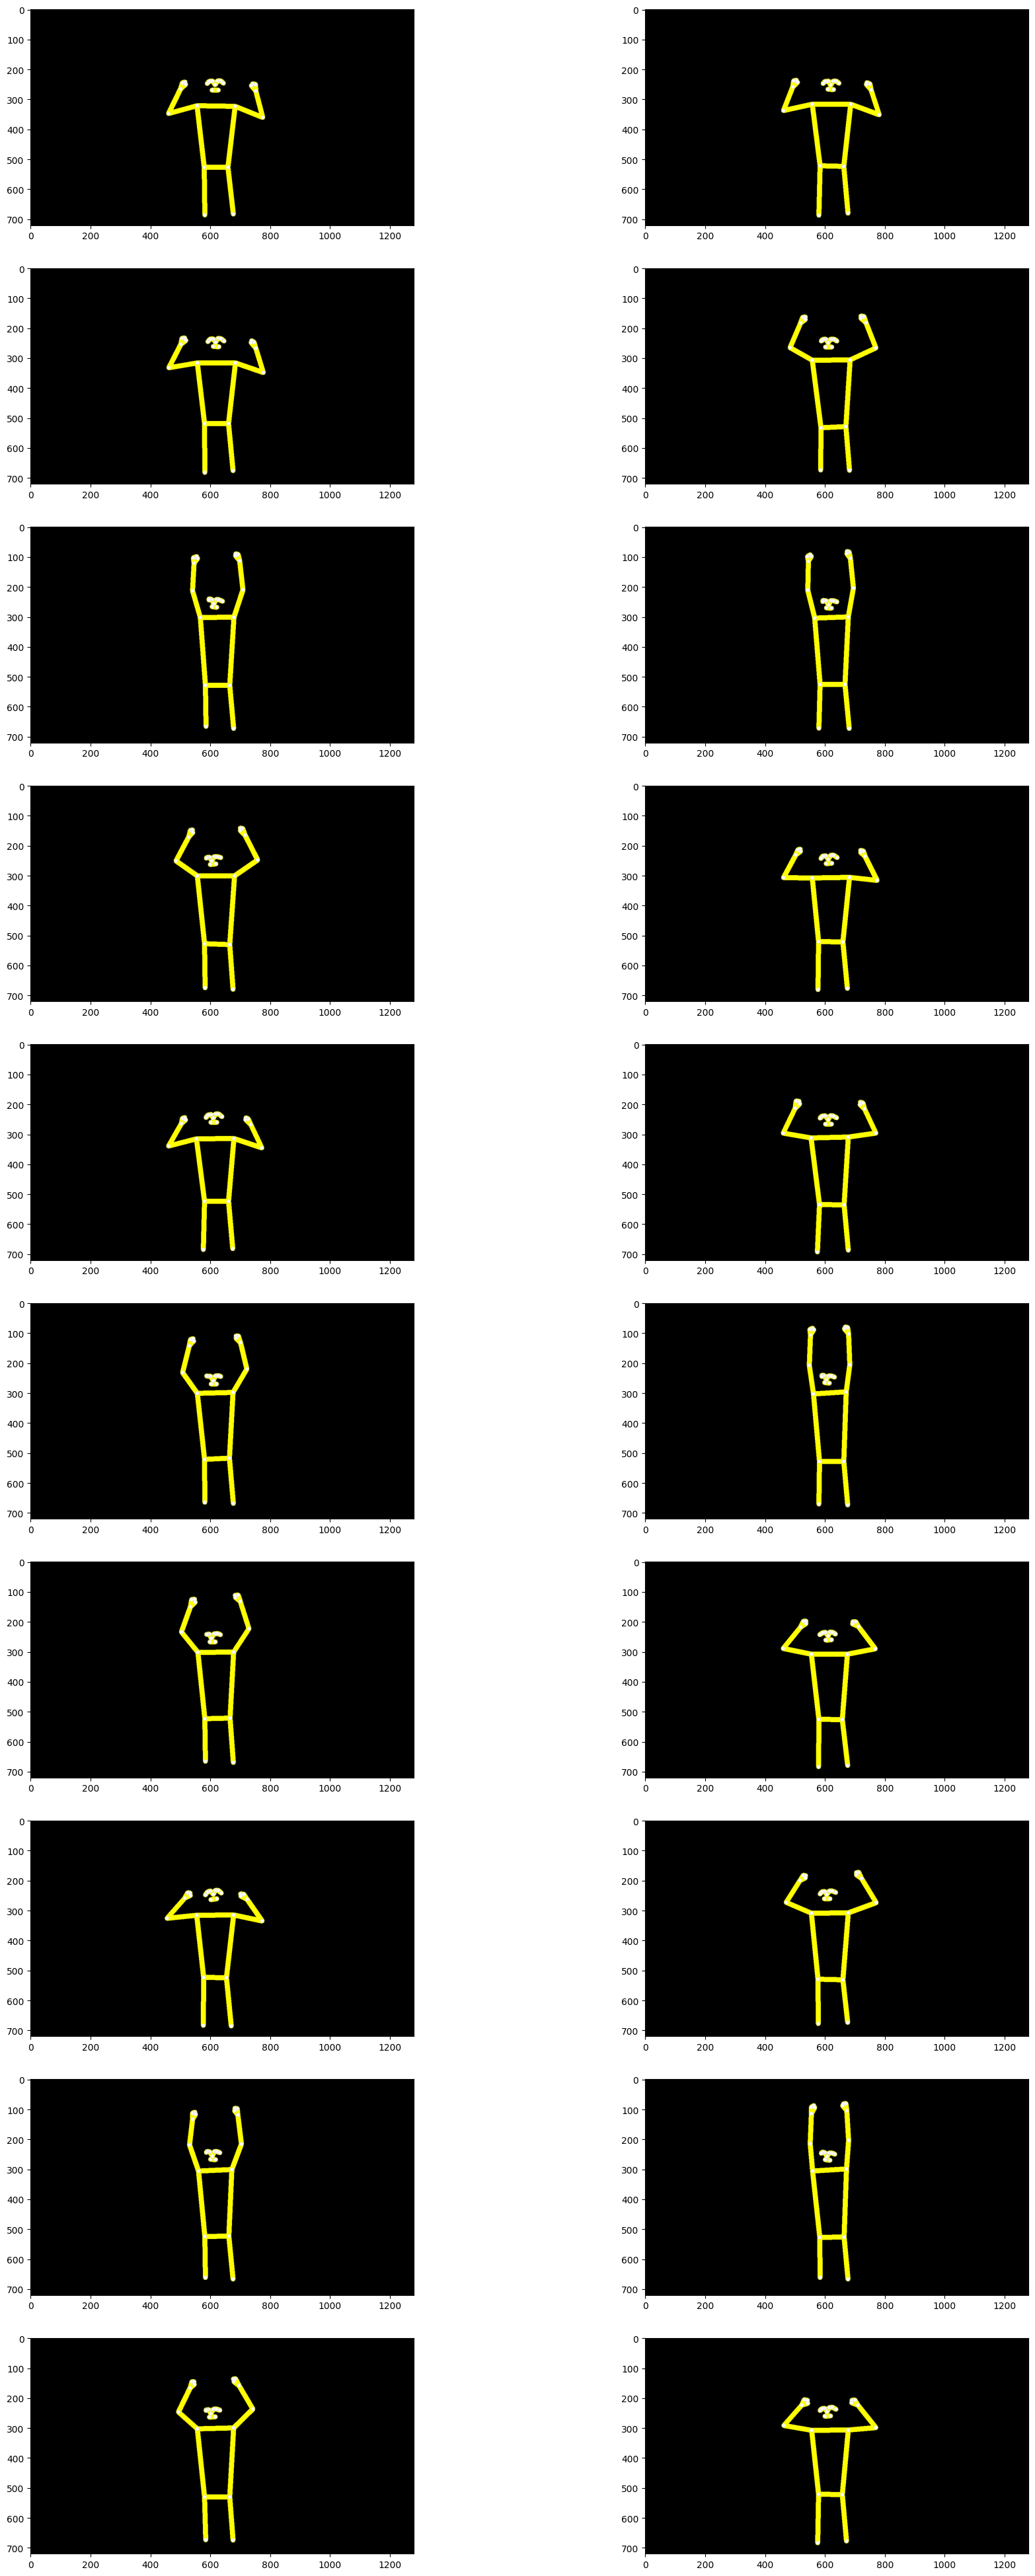

In [12]:
L, W =10, 2
fig, axes = plt.subplots(L, W, figsize = (20,50))
axes = axes.ravel()


for i in np.arange(0, L * W):  
    axes[i].imshow(frame[i])
plt.subplots_adjust(wspace=0.5)

In [89]:
# i=0
# for f in frame:
#     cv2.imwrite(f'AIFIT_DATASET/{i}.jpeg', f.astype(np.uint8))
#     i+=1
# print('Done')

In [19]:
# try:
#     for i in CLASSES_LIST:
#         print(i)
#         os.mkdir('AIFIT_DATASET/Processed Data/'+i+'/')
# except:
#     pass

Shoulder Raise
Bicep Curl


In [12]:
def save_images(class_name, frames, counter):
    processed_data_path = f'AIFIT_DATASET/Processed Data/{class_name}/'
    i=0
    folder_path = processed_data_path+str(counter)+'.mp4/'
    os.mkdir(folder_path)
    for f in frames:
        cv2.imwrite(f'{folder_path}{i}.jpg', f.astype(np.uint8))
        i+=1

In [13]:
def create_dataset():
    features = []
    labels = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = [i for i in os.listdir(f'AIFIT_DATASET/Data/{class_name}') if i.endswith('.mp4')]
        print(len(files_list))
        counter = 0
        for file_name in files_list:
            video_file_path = f'AIFIT_DATASET/Data/{class_name}/{file_name}'
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                save_images(class_name, frames, counter)
                features.append(frames)
                labels.append(class_index)
            counter += 1
    print(len(features))
    print(len(labels))

In [14]:
create_dataset()


Extracting Data of Class: Bicep Curl
224
224
224
